In [29]:
from pyforest import *
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
lazy_imports()

['import keras',
 'from sklearn.model_selection import train_test_split',
 'import numpy as np',
 'from sklearn.linear_model import LassoCV',
 'from sklearn.cluster import KMeans',
 'import tensorflow as tf',
 'import dash',
 'import gensim',
 'from pathlib import Path',
 'import fbprophet',
 'import bokeh',
 'import matplotlib as mpl',
 'from openpyxl import load_workbook',
 'import sklearn',
 'from sklearn.linear_model import ElasticNetCV',
 'from sklearn.model_selection import GridSearchCV',
 'from sklearn.ensemble import RandomForestRegressor',
 'from sklearn.preprocessing import MinMaxScaler',
 'import lightgbm as lgb',
 'import awswrangler as wr',
 'from statsmodels.tsa.arima_model import ARIMA',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'import cv2',
 'import plotly.express as px',
 'import pickle',
 'import textblob',
 'from sklearn.linear_model import Lasso',
 'from pyspark import SparkContext',
 'import re',
 'from sklearn.linear_model import ElasticNet',
 

In [30]:
# read dataset
df_covid = pd.read_csv('dataset/imputed-data.csv',header = 0)
df_covid.head()

<IPython.core.display.Javascript object>

,date,county_fips,county_name,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_visitation_grade,social_distancing_encounters_grade,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,death_ratio,population_ratio_in_state
0,2020/01/22,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
1,2020/01/23,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
2,2020/01/24,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
3,2020/01/25,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
4,2020/01/26,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047


In [31]:
# date as date format
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid['date'].head()

<IPython.core.display.Javascript object>

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
Name: date, dtype: datetime64[ns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

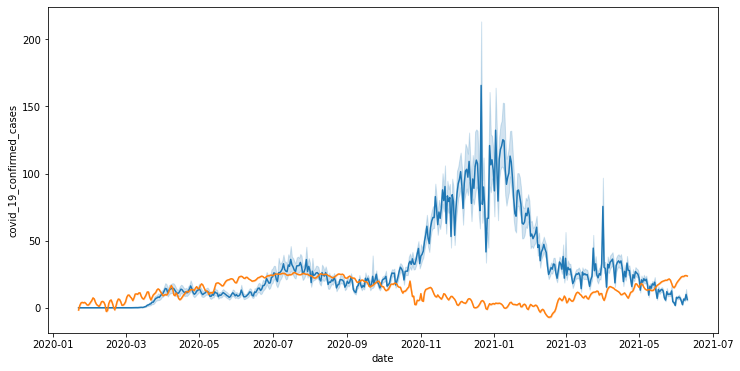

In [32]:
plt.figure(figsize = (12,6))
sns.lineplot(x = 'date', y = 'covid_19_confirmed_cases', data = df_covid)
sns.lineplot(x = 'date', y = 'temperature', data = df_covid)

In [33]:
# top high POPULATED counties
high_case = df_covid[df_covid['date'] == '2020-02-01'].groupby(['state_name'])[
    'total_population'].sum().sort_values(ascending = False)
high_case_10 = list(high_case.index[:10])
high_case_10

['California',
 'Texas',
 'Florida',
 'New York',
 'Pennsylvania',
 'Illinois',
 'North Carolina',
 'Ohio',
 'Michigan',
 'New Jersey']

In [52]:
# feature engineering
df_covid['median_household_income_bins'] = pd.qcut(df_covid['median_household_income'],q = 5).cat.codes
df_covid['smoker_bins'] = pd.qcut(df_covid['percent_of_smokers'],q = 13).cat.codes
df_covid['diabetes_bins'] = pd.qcut(df_covid['percent_of_diabetes'],q = 7).cat.codes
df_covid['no_of_death'] = df_covid['death_ratio']*df_covid['total_population']
df_covid['no_of_student_immigrants'] = df_covid['immigrant_student_ratio']*df_covid['total_population']
df_covid['social_distancing_total_grade'] = LabelEncoder().fit_transform(df_covid['social_distancing_total_grade'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
# top states filter
top_states = df_covid[df_covid['state_name'].isin(high_case_10)]
top_states = top_states.groupby(['state_fips','state_name','date'])[['virus_pressure','total_population',
                        'number_of_meat_plants', 'no_of_death', 'no_of_student_immigrants',
       'airport_distance']].mean().reset_index()
top_states.head()

,state_fips,state_name,date,virus_pressure,total_population,number_of_meat_plants,no_of_death,no_of_student_immigrants,airport_distance
0,6,California,2020-01-22,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
1,6,California,2020-01-23,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
2,6,California,2020-01-24,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
3,6,California,2020-01-25,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
4,6,California,2020-01-26,0.032253,730506.907407,12.611111,4959.259774,15321.5,94.495167


In [56]:
# create individual df for states
state_df = {}
state_ts = {}
for state in high_case_10:
    state_df[state] = pd.DataFrame(data = top_states[top_states['state_name'] == state])
    state_df[state] = state_df[state][['date','virus_pressure','total_population',
                        'number_of_meat_plants', 'no_of_death', 'no_of_student_immigrants',
       'airport_distance']].resample('D', on='date').mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# testing dfs
state_df['California'].head()

,virus_pressure,total_population,number_of_meat_plants,no_of_death,no_of_student_immigrants,airport_distance
date,,,,,,
2020-01-22,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
2020-01-23,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
2020-01-24,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
2020-01-25,0.000000,730506.907407,12.611111,4959.259774,15321.5,94.495167
2020-01-26,0.032253,730506.907407,12.611111,4959.259774,15321.5,94.495167


<AxesSubplot:xlabel='date'>

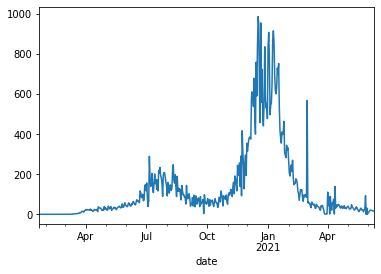

In [59]:
state_df['California']['virus_pressure'].plot()

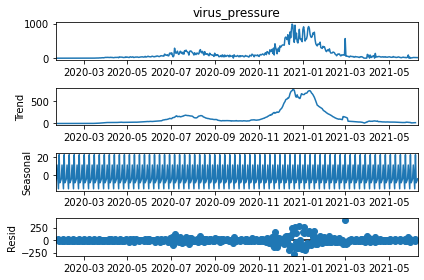

In [60]:
# check seasonal decompose
result = seasonal_decompose(state_df['California']['virus_pressure'],model = 'add')
result.plot();

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

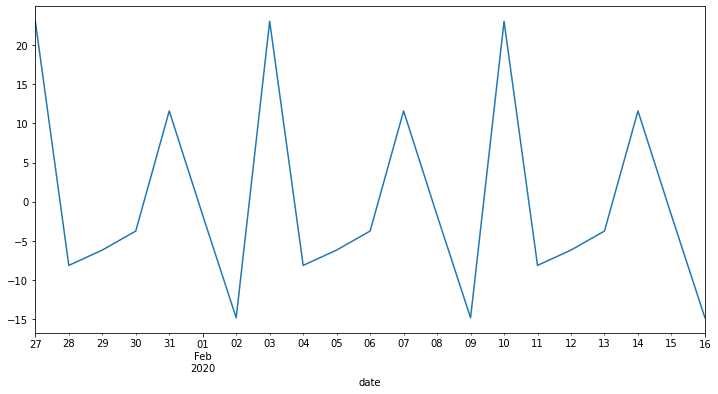

In [61]:
plt.figure(figsize = (12,6))
result.seasonal[5:26].plot()

In [62]:
# train test split
from sklearn.model_selection import train_test_split

train_df = {}
test_df = {}
future_df = {}

for state in high_case_10:
#     X_train,X_test,y_train,y_test = train_test_split(state_df[state].loc[:,
#                                                     ~state_df[state].columns.isin(['covid_19_confirmed_cases','date'])],
#                                             state_df[state]['covid_19_confirmed_cases'],test_size = 0.4,shuffle = False,
#                                                      stratify = None)

    train = state_df[state][state_df[state].index <= '2020-12-31']
    test = state_df[state][(state_df[state].index > '2020-12-31')]

    train_df[state] = train
    test_df[state] = test

<AxesSubplot:xlabel='date'>

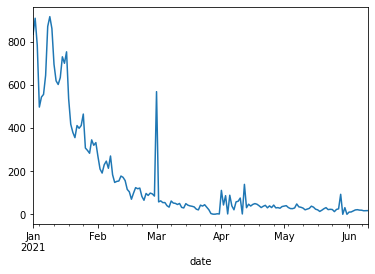

In [63]:
test_df['California']['virus_pressure'].plot()

In [76]:
# auto_arima fit #c
from pmdarima import auto_arima
model_cal = auto_arima(state_df['California']['virus_pressure'],seasonal = True,m = 7,trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=5624.784, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5787.508, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5683.316, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5636.097, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5785.508, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=5629.165, Time=0.97 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=5623.492, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=5670.039, Time=0.51 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=5625.073, Time=1.30 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=5625.395, Time=2.30 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=5622.781, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=5668.534, Time=0.28 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=5624.227, Time=1.19 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=5623.855, Time=1.26 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

In [77]:
model_cal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  506
Model:             SARIMAX(0, 1, 4)x(1, 0, [], 7)   Log Likelihood               -2803.416
Date:                            Mon, 04 Apr 2022   AIC                           5618.832
Time:                                    00:20:50   BIC                           5644.179
Sample:                                         0   HQIC                          5628.774
                                            - 506                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5395      0.018    -30.479      0.000      -0.574      -0.505
ma.L2         -0.1138      0.022     -5.079      0.000      -0.158      -0.070
ma.L3         -0.0871      0.023     -3.836      0.000      -0.132      -0.043
ma.L4          0.0730      0.021      3.535      0.000       0.033       0.113
ar.S.L7        0.2911      0.019     15.483      0.000       0.254       0.328
sigma2      3875.7408     85.738     45.204      0.000    3707.697    4043.784
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5034.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              19.10   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
# forecast first
forecast['California'] = model_cal.predict(n_periods = 7)

In [79]:
forecast['California']

array([18.81996833, 19.20913429, 18.64142275, 18.53646998, 17.79910557,
       17.91830816, 17.99894169])

In [49]:
test_df['California'][:7]

,virus_pressure
date,
2021-01-01,833.769055
2021-01-02,907.958385
2021-01-03,782.561978
2021-01-04,496.652050
2021-01-05,542.970606
2021-01-06,555.244187
2021-01-07,643.839227


In [74]:
#forecast plot
plt.figure(figsize = (12,6))
#sns.lineplot(x = test_df['California'].iloc[:161].index,y = test_df['California'].iloc[:161],label = 'real',legend = True)
sns.lineplot(x = forecast['California'].index, y = forecast['California']['virus_pressure'],label = 'forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 864x432 with 0 Axes>